In [10]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [11]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [12]:
x_train, y_train,x_test, y_test = load_data()

In [13]:
x_train_normalized, x_test_normalized=np.array(x_train)/255, np.array(x_test)/255
x_train_reshaped = x_train_normalized.reshape((x_train_normalized.shape[0], 48, 48, 1))
x_test_reshaped = x_test_normalized.reshape((x_test_normalized.shape[0], 48, 48, 1))

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        probabilities=model.predict_proba(X_train)
        aucs= []
        for i in range(len(unique_labels)):
            fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels[i]).astype(int), probabilities[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
            aucs.append(roc_auc_dt)
    except:
        aucs = 0
    auc_df = pd.DataFrame({'AUC': aucs}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

https://www.tensorflow.org/tutorials/images/cnn

https://colab.research.google.com/drive/1uWZQ-lzAk5308YVjMW5XaZcS_3zmGSgN?usp=sharing

In [85]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    # pooling input layer
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [88]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

Epoch 1/10
152/152 [==============================] - 2s 11ms/step - loss: 2.7970 - accuracy: 0.2971 - val_loss: 1.8316 - val_accuracy: 0.2385
Epoch 2/10
152/152 [==============================] - 1s 10ms/step - loss: 1.6959 - accuracy: 0.3357 - val_loss: 1.7379 - val_accuracy: 0.3123
Epoch 3/10
152/152 [==============================] - 1s 9ms/step - loss: 1.5409 - accuracy: 0.3840 - val_loss: 1.4977 - val_accuracy: 0.3906
Epoch 4/10
152/152 [==============================] - 1s 10ms/step - loss: 1.3407 - accuracy: 0.4751 - val_loss: 1.2950 - val_accuracy: 0.5129
Epoch 5/10
152/152 [==============================] - 1s 10ms/step - loss: 1.1383 - accuracy: 0.5718 - val_loss: 1.3707 - val_accuracy: 0.4874
Epoch 6/10
152/152 [==============================] - 1s 10ms/step - loss: 1.0742 - accuracy: 0.6001 - val_loss: 1.0834 - val_accuracy: 0.6162
Epoch 7/10
152/152 [==============================] - 1s 9ms/step - loss: 1.0246 - accuracy: 0.6207 - val_loss: 1.1296 - val_accuracy: 0.6094
E

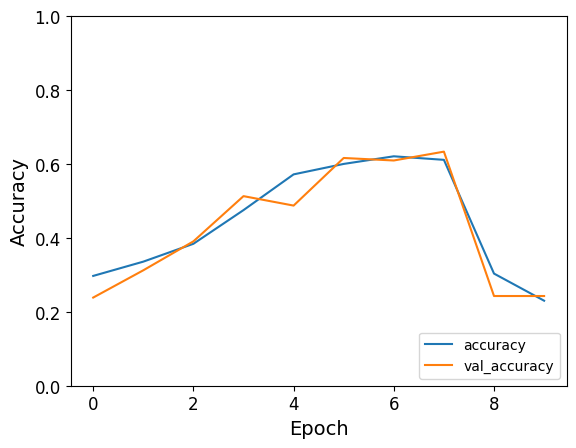

In [89]:
num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.1)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, 
                         validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 2s 12ms/step - loss: 1.3843 - accuracy: 0.4925 - val_loss: 0.8169 - val_accuracy: 0.7178
Epoch 2/10
152/152 [==============================] - 2s 10ms/step - loss: 0.4052 - accuracy: 0.8644 - val_loss: 0.4010 - val_accuracy: 0.8631
Epoch 3/10
152/152 [==============================] - 1s 10ms/step - loss: 0.2403 - accuracy: 0.9183 - val_loss: 0.3914 - val_accuracy: 0.8670
Epoch 4/10
152/152 [==============================] - 1s 10ms/step - loss: 0.1769 - accuracy: 0.9424 - val_loss: 0.3894 - val_accuracy: 0.8738
Epoch 5/10
152/152 [==============================] - 1s 10ms/step - loss: 0.1492 - accuracy: 0.9515 - val_loss: 0.4087 - val_accuracy: 0.8683
Epoch 6/10
152/152 [==============================] - 2s 10ms/step - loss: 0.1315 - accuracy: 0.9570 - val_loss: 0.4031 - val_accuracy: 0.8812
Epoch 7/10
152/152 [==============================] - 1s 9ms/step - loss: 0.1041 - accuracy: 0.9642 - val_loss: 0.4749 - val_accuracy: 0.8741


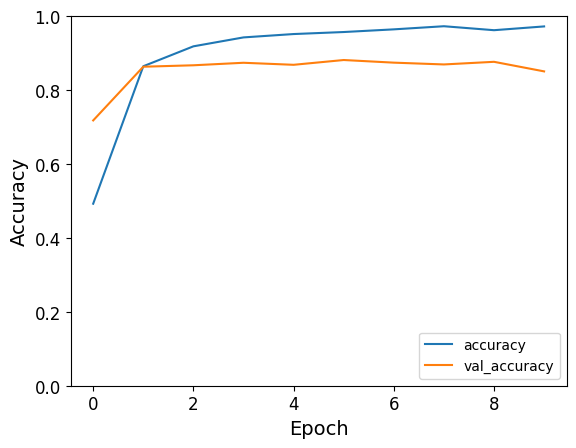

In [90]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.01)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 2s 11ms/step - loss: 1.5989 - accuracy: 0.4149 - val_loss: 1.3924 - val_accuracy: 0.5236
Epoch 2/10
152/152 [==============================] - 2s 10ms/step - loss: 0.9670 - accuracy: 0.6802 - val_loss: 0.9593 - val_accuracy: 0.7058
Epoch 3/10
152/152 [==============================] - 1s 10ms/step - loss: 0.5847 - accuracy: 0.8360 - val_loss: 0.6727 - val_accuracy: 0.7825
Epoch 4/10
152/152 [==============================] - 1s 9ms/step - loss: 0.3892 - accuracy: 0.8918 - val_loss: 0.4983 - val_accuracy: 0.8379
Epoch 5/10
152/152 [==============================] - 1s 9ms/step - loss: 0.2827 - accuracy: 0.9236 - val_loss: 0.4001 - val_accuracy: 0.8702
Epoch 6/10
152/152 [==============================] - 2s 10ms/step - loss: 0.2282 - accuracy: 0.9363 - val_loss: 0.3644 - val_accuracy: 0.8858
Epoch 7/10
152/152 [==============================] - 1s 10ms/step - loss: 0.1857 - accuracy: 0.9502 - val_loss: 0.3897 - val_accuracy: 0.8790
E

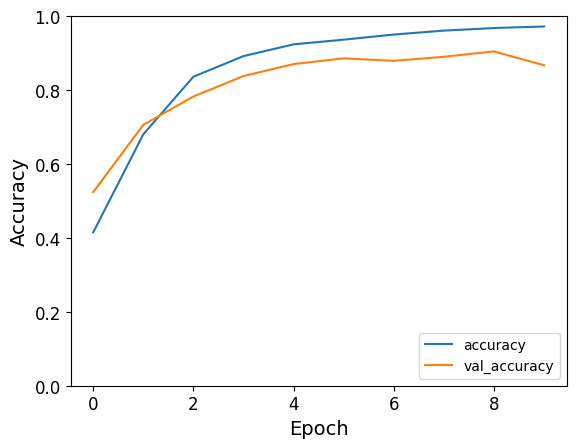

In [91]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 2s 11ms/step - loss: 1.9306 - accuracy: 0.2750 - val_loss: 1.8696 - val_accuracy: 0.3634
Epoch 2/10
152/152 [==============================] - 2s 10ms/step - loss: 1.7094 - accuracy: 0.3935 - val_loss: 1.7076 - val_accuracy: 0.3463
Epoch 3/10
152/152 [==============================] - 2s 10ms/step - loss: 1.5421 - accuracy: 0.4418 - val_loss: 1.6119 - val_accuracy: 0.4181
Epoch 4/10
152/152 [==============================] - 2s 10ms/step - loss: 1.4187 - accuracy: 0.4939 - val_loss: 1.5242 - val_accuracy: 0.4599
Epoch 5/10
152/152 [==============================] - 1s 10ms/step - loss: 1.3072 - accuracy: 0.5360 - val_loss: 1.4448 - val_accuracy: 0.5149
Epoch 6/10
152/152 [==============================] - 2s 11ms/step - loss: 1.2085 - accuracy: 0.5895 - val_loss: 1.3803 - val_accuracy: 0.5476
Epoch 7/10
152/152 [==============================] - 2s 11ms/step - loss: 1.1175 - accuracy: 0.6428 - val_loss: 1.3019 - val_accuracy: 0.5735

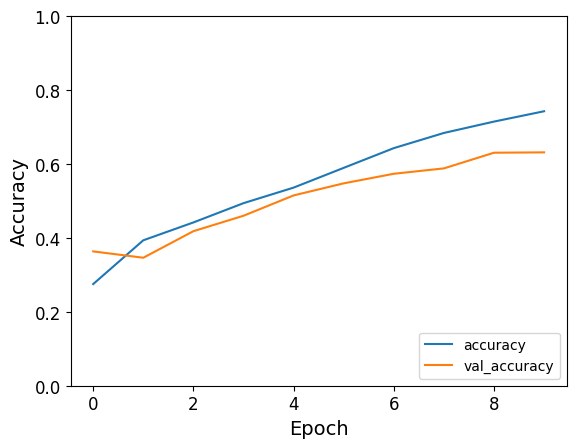

In [92]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.0001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 2s 11ms/step - loss: 2.1861 - accuracy: 0.2120 - val_loss: 2.1097 - val_accuracy: 0.2330
Epoch 2/10
152/152 [==============================] - 2s 10ms/step - loss: 2.0437 - accuracy: 0.2321 - val_loss: 2.0115 - val_accuracy: 0.2375
Epoch 3/10
152/152 [==============================] - 2s 10ms/step - loss: 1.9641 - accuracy: 0.2517 - val_loss: 1.9594 - val_accuracy: 0.2812
Epoch 4/10
152/152 [==============================] - 1s 10ms/step - loss: 1.9187 - accuracy: 0.2915 - val_loss: 1.9291 - val_accuracy: 0.3023
Epoch 5/10
152/152 [==============================] - 1s 10ms/step - loss: 1.8882 - accuracy: 0.3191 - val_loss: 1.9088 - val_accuracy: 0.3165
Epoch 6/10
152/152 [==============================] - 2s 10ms/step - loss: 1.8649 - accuracy: 0.3267 - val_loss: 1.8928 - val_accuracy: 0.3172
Epoch 7/10
152/152 [==============================] - 2s 11ms/step - loss: 1.8448 - accuracy: 0.3444 - val_loss: 1.8788 - val_accuracy: 0.3825

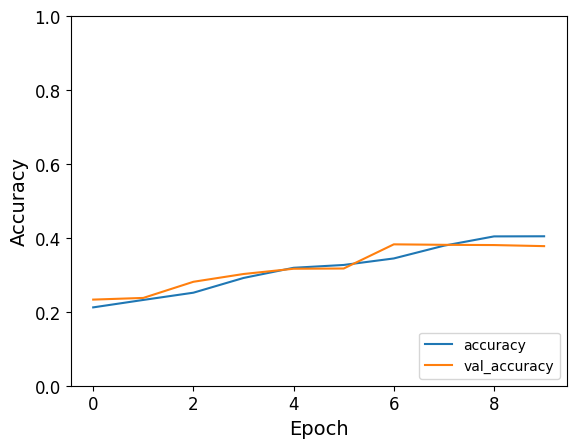

In [93]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes, kernel=kernel,strides=strides,learning_rate=0.00001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

In [122]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


Epoch 1/10
152/152 [==============================] - 3s 14ms/step - loss: 1.8820 - accuracy: 0.2892 - val_loss: 1.7447 - val_accuracy: 0.3097
Epoch 2/10
152/152 [==============================] - 2s 12ms/step - loss: 1.4931 - accuracy: 0.4245 - val_loss: 1.5024 - val_accuracy: 0.4275
Epoch 3/10
152/152 [==============================] - 2s 13ms/step - loss: 1.1745 - accuracy: 0.5568 - val_loss: 1.3292 - val_accuracy: 0.5159
Epoch 4/10
152/152 [==============================] - 2s 12ms/step - loss: 0.8765 - accuracy: 0.6879 - val_loss: 1.0646 - val_accuracy: 0.6644
Epoch 5/10
152/152 [==============================] - 2s 12ms/step - loss: 0.6456 - accuracy: 0.7700 - val_loss: 0.8589 - val_accuracy: 0.7450
Epoch 6/10
152/152 [==============================] - 2s 12ms/step - loss: 0.4933 - accuracy: 0.8276 - val_loss: 0.7410 - val_accuracy: 0.7858
Epoch 7/10
152/152 [==============================] - 2s 11ms/step - loss: 0.3775 - accuracy: 0.8721 - val_loss: 0.7478 - val_accuracy: 0.7809

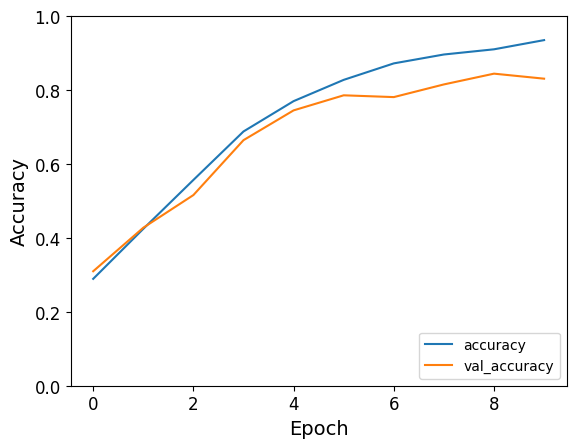

In [123]:
# best LR so far 0.001
model = create_cnn_ex(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

In [124]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex2(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


Epoch 1/10
152/152 [==============================] - 3s 13ms/step - loss: 1.7110 - accuracy: 0.3641 - val_loss: 1.4378 - val_accuracy: 0.5362
Epoch 2/10
152/152 [==============================] - 2s 12ms/step - loss: 0.9452 - accuracy: 0.6707 - val_loss: 0.8406 - val_accuracy: 0.7074
Epoch 3/10
152/152 [==============================] - 2s 12ms/step - loss: 0.5075 - accuracy: 0.8354 - val_loss: 0.5252 - val_accuracy: 0.8317
Epoch 4/10
152/152 [==============================] - 2s 12ms/step - loss: 0.3077 - accuracy: 0.9068 - val_loss: 0.4126 - val_accuracy: 0.8764
Epoch 5/10
152/152 [==============================] - 2s 11ms/step - loss: 0.2271 - accuracy: 0.9341 - val_loss: 0.3844 - val_accuracy: 0.8751
Epoch 6/10
152/152 [==============================] - 2s 11ms/step - loss: 0.1623 - accuracy: 0.9544 - val_loss: 0.3715 - val_accuracy: 0.8871
Epoch 7/10
152/152 [==============================] - 2s 12ms/step - loss: 0.1287 - accuracy: 0.9625 - val_loss: 0.3502 - val_accuracy: 0.8858

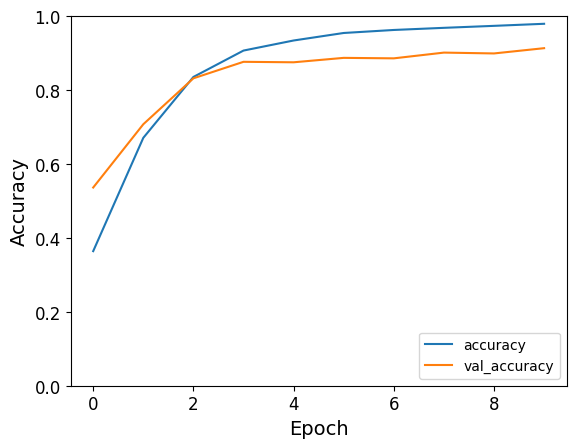

In [125]:
# best LR so far 0.001
model = create_cnn_ex2(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier


In [127]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

input_shape = x_train_reshaped.shape[1:]

param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [10],
    'learning_rate': [0.01],
    'kernel': [(3, 3), (5, 5)],
    'strides': [(1, 1), (2, 2)],
    'filters': [32, 64, 128],
    'dense_units': [64, 128],
}

model = KerasClassifier(build_fn=create_cnn_ex2, verbose=2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_result = grid.fit(x_train_reshaped, y_train)

C:\Users\ishaq\AppData\Local\Temp\ipykernel_5008\1250075556.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, verbose=2)


Epoch 1/10
273/273 - 14s - loss: 1.1112 - accuracy: 0.5987 - 14s/epoch - 51ms/step
Epoch 2/10


KeyboardInterrupt: 

from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)